#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [31]:
df_stock1 = pd.read_csv("../static/data/csl.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT
0,3/01/2000,7.300000,7.300000,7.300000,7.300000,5.234562,0.0,NEGATIVE
1,4/01/2000,7.333333,7.333333,7.066666,7.186666,5.153295,254295.0,NEGATIVE
2,5/01/2000,7.000000,7.183333,7.000000,7.155000,5.130589,424941.0,NEGATIVE
3,6/01/2000,7.233333,7.273333,7.000000,7.000000,5.019443,348534.0,NEGATIVE
4,7/01/2000,7.013000,7.023333,6.800000,6.850000,4.911883,483963.0,POSITIVE


<AxesSubplot:>

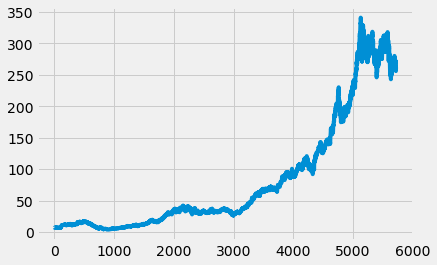

In [32]:
df["Close"].plot()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5687 entries, 0 to 5721
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5687 non-null   object 
 1   Open       5687 non-null   float64
 2   High       5687 non-null   float64
 3   Low        5687 non-null   float64
 4   Close      5687 non-null   float64
 5   Adj Close  5687 non-null   float64
 6   Volume     5687 non-null   float64
 7   SENTIMENT  5687 non-null   object 
dtypes: float64(6), object(2)
memory usage: 399.9+ KB


In [34]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5687, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [35]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4550, 1)

In [36]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01017412, 0.00983794, 0.00974402, 0.00928425, 0.00883932,
       0.01027299, 0.01022355, 0.01047074, 0.01037186, 0.01072781,
       0.01096511, 0.01091567, 0.01096511, 0.01141004, 0.01101454,
       0.01086623, 0.01081581, 0.01145948, 0.01126173, 0.01135368,
       0.01145948, 0.01150891, 0.01154846, 0.01155835, 0.01160779,
       0.01096511, 0.01111342, 0.01126173, 0.01056961, 0.01041141,
       0.01037186, 0.01003569, 0.00937719, 0.00899653, 0.00903707,
       0.00898763, 0.00898763, 0.00943256, 0.00933369, 0.009482  ,
       0.01007524, 0.00999515, 0.009482  , 0.00862773, 0.00918538,
       0.00928425, 0.00898763, 0.00903707, 0.0097806 , 0.00997637,
       0.00997637, 0.00997637, 0.01037186, 0.01032243, 0.01039362,
       0.01056961, 0.01066848, 0.01047074, 0.01027299, 0.01047074])]
[0.010477658470026397]


# Prepare train data for LSTM model

In [37]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4490, 60)

In [38]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4490, 60, 1)

# Build the LSTM model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [40]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [41]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4490/4490 [==============================] - 78s 17ms/step - loss: 1.8314e-04


In [42]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [43]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [44]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [45]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

21.958946999132515

C:\Users\antoi\AppData\Local\Temp/ipykernel_2600/1751790871.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


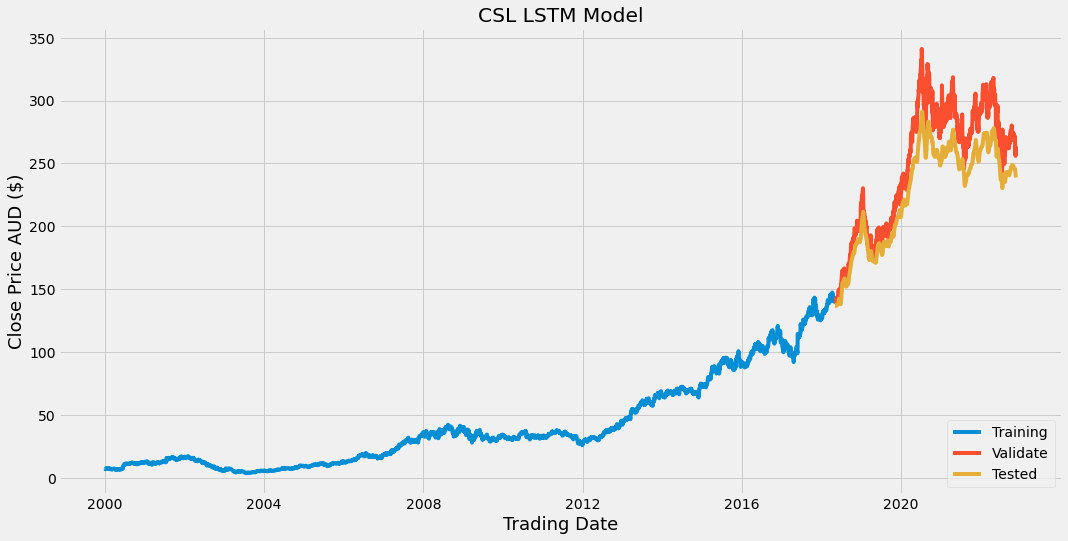

In [46]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('CSL LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/csl_graph.png')
plt.show()


# Test data Predictions on the Model

In [47]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_2600/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4585,141.059998,137.205414,3.854584
4586,141.199997,137.219879,3.980118
4587,141.130005,137.213104,3.916901
4588,140.929993,137.186737,3.743256
4589,141.300003,137.130005,4.169998
...,...,...,...
5717,258.679993,243.727219,14.952774
5718,255.990005,242.202637,13.787368
5719,263.029999,240.441406,22.588593
5720,260.000000,239.562714,20.437286


In [48]:
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB
db.csl.drop()

import csv
header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
csvfile = open('../static/data/csl.csv', 'r')
reader = csv.DictReader( csvfile )

for each in reader:
    row={}
    for field in header:
        row[field]=each[field]
        
    print (row)
    db.csl.insert_one(row)				

{'Date': '3/01/2000', 'Open': '7.3', 'High': '7.3', 'Low': '7.3', 'Close': '7.3', 'Adj Close': '5.234562', 'Volume': '0', 'SENTIMENT': 'NEGATIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '4/01/2000', 'Open': '7.333333', 'High': '7.333333', 'Low': '7.066666', 'Close': '7.186666', 'Adj Close': '5.153295', 'Volume': '254295', 'SENTIMENT': 'NEGATIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '5/01/2000', 'Open': '7', 'High': '7.183333', 'Low': '7', 'Close': '7.155', 'Adj Close': '5.130589', 'Volume': '424941', 'SENTIMENT': 'NEGATIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '6/01/2000', 'Open': '7.233333', 'High': '7.273333', 'Low': '7', 'Close': '7', 'Adj Close': '5.019443', 'Volume': '348534', 'SENTIMENT': 'NEGATIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '7/01/2000', 'Open': '7.013', 'High': '7.023333', 'Low': '6.8', 'Close': '6.85', 'Adj Close': '4.911883', 'Volume': '483963', 'SENTIMENT': 'POSITIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '10/01/2000', 'Open': '7', 'High': '7.333333', 'Low': '7', 'Close': '

In [49]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'CSL.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR use csv data 

In [50]:
# Use last 60 days price on model to predict next days price
stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']
last_60_days = stock_close_sixty[-60:].values
last_60_days = last_60_days.reshape(-1,1)
last_60_days.shape

(60, 1)

In [51]:
last_60_days_scaled = scaler.transform(last_60_days)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [52]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'Predicted next day share price {pred_price}')

Predicted next day share price 238


In [53]:
#stock_quote_acual = web.DataReader('CSL.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv
stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one

,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED,CPI
5725,28/06/2022,272.730011,274.529999,270.725006,274.029999,274.029999,723654.0,POSITIVE,0.85,1.75,NaN


In [54]:
#save actual to variable
actual_price = stock_quote_last_one.iloc[0,4]
actual_date = stock_quote_last_one.iloc[0,0] 
actual_price = int(actual_price)
actual_price
actual_date

'28/06/2022'

# Save the Model

In [55]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/csl_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list csl_sixty and load df

#PREDICT USING LOADED MODEL

In [56]:
from keras.models import load_model
model_in = load_model('../static/csl_model.sav')

In [57]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)
# create a connection to the sharesDb for the csl collection
db_csl = client.sharesDB.csl

# query the csl collection and load into dataframe
import pandas as pd

df_mongo = pd.DataFrame(list(db_csl.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

NameError: name 'pymongo' is not defined

#Create a function to loop through the days input

In [ ]:
from keras.models import load_model
model_in = load_model('../static/csl_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# # Read in the CSV file
# csldump_sixty = pd.read_csv("../static/data/csl.csv")
# csldump_sixty = csldump_sixty.dropna()
# csldump_sixty = csldump_sixty.iloc[-4250:]
# sixty_val = csldump_sixty.iloc[-60:,4].values
# last_sixty = sixty_val.reshape(-1,1)

price_list=[]

#Function to predict future days predicted price, in loop
input = 100 #days
if input == "":
    input = 100
else:
   input = int(input)

def predict_csl(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    print(price_list)

In [ ]:
predict_csl(last_sixty,model_in,input)

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

In [ ]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df

,Count,Date,DOW
0,1,29/06/2022,Wednesday
1,2,30/06/2022,Thursday
2,3,1/07/2022,Friday
3,4,2/07/2022,Monday
4,5,3/07/2022,Tuesday
...,...,...,...
377,0,11/07/2023,Friday
378,0,12/07/2023,Monday
379,0,13/07/2023,Tuesday
380,0,14/07/2023,Wednesday


In [ ]:
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict

C:\Users\antoi\AppData\Local\Temp/ipykernel_2272/2919172947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


[{'Count': 1, 'Date': '29/06/2022', 'DOW': 'Wednesday', 'Price': 267.74},
 {'Count': 2, 'Date': '30/06/2022', 'DOW': 'Thursday', 'Price': 268.58},
 {'Count': 3, 'Date': '1/07/2022', 'DOW': 'Friday', 'Price': 268.99},
 {'Count': 4, 'Date': '2/07/2022', 'DOW': 'Monday', 'Price': 269.2},
 {'Count': 5, 'Date': '3/07/2022', 'DOW': 'Tuesday', 'Price': 269.32},
 {'Count': 6, 'Date': '4/07/2022', 'DOW': 'Wednesday', 'Price': 269.41},
 {'Count': 7, 'Date': '5/07/2022', 'DOW': 'Thursday', 'Price': 269.48},
 {'Count': 8, 'Date': '6/07/2022', 'DOW': 'Friday', 'Price': 269.54},
 {'Count': 9, 'Date': '7/07/2022', 'DOW': 'Monday', 'Price': 269.6},
 {'Count': 10, 'Date': '8/07/2022', 'DOW': 'Tuesday', 'Price': 269.65},
 {'Count': 11, 'Date': '9/07/2022', 'DOW': 'Wednesday', 'Price': 269.71},
 {'Count': 12, 'Date': '10/07/2022', 'DOW': 'Thursday', 'Price': 269.76},
 {'Count': 13, 'Date': '11/07/2022', 'DOW': 'Friday', 'Price': 269.82},
 {'Count': 14, 'Date': '12/07/2022', 'DOW': 'Monday', 'Price': 269.

In [ ]:
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 267.74},
 {'Price': 268.58},
 {'Price': 268.99},
 {'Price': 269.2},
 {'Price': 269.32},
 {'Price': 269.41},
 {'Price': 269.48},
 {'Price': 269.54},
 {'Price': 269.6},
 {'Price': 269.65},
 {'Price': 269.71},
 {'Price': 269.76},
 {'Price': 269.82},
 {'Price': 269.87},
 {'Price': 269.93},
 {'Price': 269.98},
 {'Price': 270.04},
 {'Price': 270.1},
 {'Price': 270.15},
 {'Price': 270.21},
 {'Price': 270.27},
 {'Price': 270.33},
 {'Price': 270.38},
 {'Price': 270.44},
 {'Price': 270.5},
 {'Price': 270.56},
 {'Price': 270.62},
 {'Price': 270.68},
 {'Price': 270.74},
 {'Price': 270.78},
 {'Price': 270.8},
 {'Price': 270.84},
 {'Price': 270.89},
 {'Price': 270.94},
 {'Price': 270.95},
 {'Price': 270.99},
 {'Price': 271.02},
 {'Price': 271.05},
 {'Price': 271.09},
 {'Price': 271.12},
 {'Price': 271.15},
 {'Price': 271.19},
 {'Price': 271.22},
 {'Price': 271.25},
 {'Price': 271.28},
 {'Price': 271.32},
 {'Price': 271.35},
 {'Price': 271.38},
 {'Price': 271.41},
 {'Price': 271.44},
 {'Pr

In [ ]:
# DRAW THE PREDICTION
df_len = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,df_len,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4552 5690 5790


,Close
5779,271.59
5780,271.59
5781,271.59
5782,271.59
5783,271.59
5784,271.60
5785,271.60
5786,271.60
5787,271.60
5788,271.60


In [ ]:
# import plotly.graph_objects as go

C:\Users\antoi\AppData\Local\Temp/ipykernel_2272/1931113616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


<Figure size 432x288 with 0 Axes>

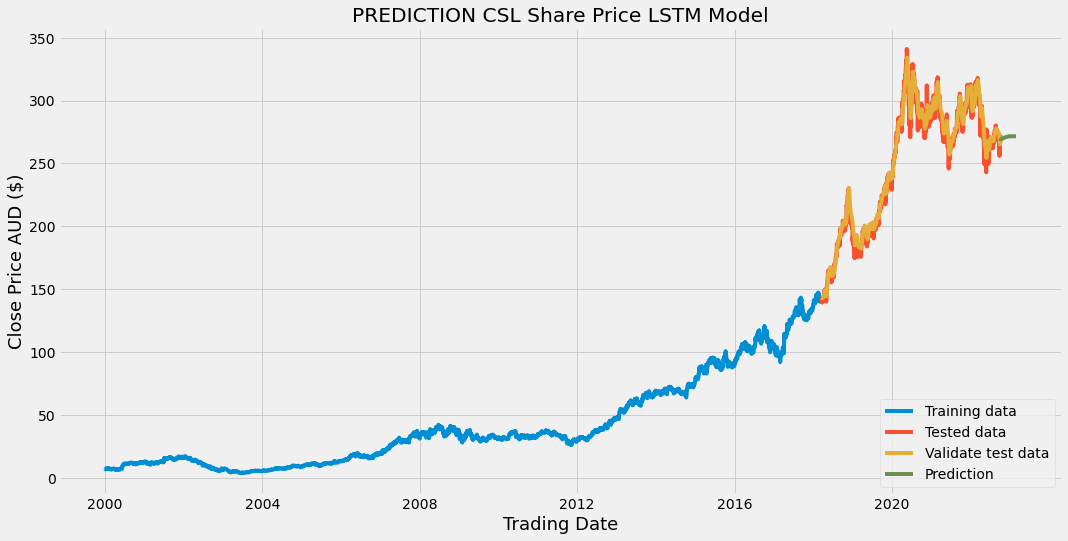

In [ ]:
#Plot the data to validate the test data
plt.clf()
plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:df_len] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[df_len:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION CSL Share Price LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/csl_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [ ]:
# Module used to connect Python with MongoDb
import pymongo

In [ ]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

In [ ]:
# Query all
# Here, db.companys refers to the collection 'companys '
company_rsme = db.find_one({'name': 'CSL'},{'rsme': 'rsme'})

# Iterate through each company in the collection
for company in company_rsme:
    print(company)

_id
rsme


In [ ]:
# Set keys and values of company
name = 'CSL'
predicted = int(pred_price)
difference = pred_price-actual_price
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}, rmse {round(rmse,5)}')

date 28/06/2022,predicted 269,actual 274, difference -5, rmse 2.37099


In [ ]:
# Delete a document from a collection
db.delete_one(
    {'name': 'CSL'}
)

# query the classroom collection
companys = db.find()
# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62bbc7cb193d5e9ca1048e2b'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.32984}
{'_id': ObjectId('62bbca7acc73d07c34c73fbb'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 19, 'actual': 19, 'differece': 0, 'rmse': 0.15231}
{'_id': ObjectId('62bbdd4da0c646d0f72fcefa'), 'model': 'RFR', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 97, 'actual': 93, 'differece': 4.07686528417301, 'accuracy': 97.51}
{'_id': ObjectId('62be5c40e95d9c2fd3be8c1f'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 40, 'actual': 42, 'differece': -2, 'rmse': 0.06586}
{'_id': ObjectId('62be7229a83f80add8272115'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 88, 'actual': 93, 'differece': -5, 'rmse': 2.06539}


In [ ]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'differece': difference,
      'rmse': round(rmse,5)  
    }
)

# query the classroom collection
companys = db.find()
# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62bbc7cb193d5e9ca1048e2b'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.32984}
{'_id': ObjectId('62bbca7acc73d07c34c73fbb'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 19, 'actual': 19, 'differece': 0, 'rmse': 0.15231}
{'_id': ObjectId('62bbdd4da0c646d0f72fcefa'), 'model': 'RFR', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 97, 'actual': 93, 'differece': 4.07686528417301, 'accuracy': 97.51}
{'_id': ObjectId('62be5c40e95d9c2fd3be8c1f'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 40, 'actual': 42, 'differece': -2, 'rmse': 0.06586}
{'_id': ObjectId('62be7229a83f80add8272115'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 88, 'actual': 93, 'differece': -5, 'rmse': 2.06539}
{'_id': ObjectId('62be73734cebc85c036027db'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 269, 'actual': 274, 'differece': -5, 'rmse': 2.37

In [ ]:
# # query the collection
# csls = db.csl.find()

# # see change in collection
# for csl in csls:
#     print(csl)